In [2]:
import networkx as nx
import numpy as np
from scipy.sparse import csr_array
from scipy.sparse import diags
import matplotlib.pyplot as plt

In [3]:
rng = np.random.default_rng(0)
probs = np.array([
    [0.9, 0.01, 0.01],
    [0.01, 0.9, 0.01],
    [0.01, 0.01, 0.9],
])
# probs = np.array([
#     [0.4, 0.01, 0.01],
#     [0.01, 0.4, 0.01],
#     [0.01, 0.01, 0.4],
# ])
# probs = np.array([
#     [0.4, 0.4, 0.01],
#     [0.4, 0., 0.01],
#     [0.01, 0.01, 0.42],
# ])
# sizes = rng.poisson(111, size=3)
sizes = rng.poisson(555, size=3)
graph = nx.stochastic_block_model(sizes, probs, seed=rng)
labels = [b for n, b in graph.nodes(data='block')]
num = sizes.shape[0]


In [4]:
# SEED = 123
# X += np.random.default_rng(SEED).normal(size=(len(G.nodes), k), scale=1/100)

In [5]:
eps = 1e-8

def hardmax(X):
    Y = np.zeros_like(X)
    Y[np.arange(X.shape[0]), X.argmax(1)] = 1
    return Y

def sbm_slow(G, k, *,
             likelihood='bernoulli',
             alpha=0.,
             weight=None,
             track_scores=False,
             max_iter=100,
             min_epochs=10,
             tol=0.01):
    # This approach implements the method exactly as derived

    # Adjacency matrix
    A = nx.to_scipy_sparse_array(G, weight=weight).astype(float)
    A_dense = A.toarray() if track_scores else None

    if likelihood == 'bernoulli':
        assert ((A.data==0) | (A.data==1)).all()
    elif likelihood == 'poisson':
        assert (A.data >= 0).all() and (A.data == A.data.round()).all()
    elif likelihood == 'normal':
        pass
    else:
        raise ValueError

    # Soft partition matrix
    X = np.ones((len(G.nodes), k)) / k
    X += np.random.randn(len(G.nodes), k) / 100
    # Hard partition matrix
    Z = hardmax(X)
    partition = Z.argmax(1)

    # Structure matrix sufficient statistics
    M = Z.T @ (A @ Z)
    n = Z.sum(0)[:, None]
    # Structure matrix MLE
    B = M / (n@n.T).clip(1, None)

    # Regularization
    R = np.eye(k) * alpha

    if track_scores:
        # Initialize trace of scores
        P = np.clip(Z@B@Z.T, eps, 1-eps)
        if likelihood == 'bernoulli':
            L = A_dense * np.log(P) + (1-A_dense) * np.log(1-P)
        elif likelihood == 'poisson':
            L = A_dense * np.log(P) - P
        elif likelihood == 'normal':
            L = 1/2 * (A_dense - P)**2
        trace = [L.mean()]

    for epoch in range(max_iter):

        # Compute predictions
        P = np.clip(Z@B@Z.T, eps, 1-eps)
        if likelihood == 'bernoulli':
            w = (1 / P / (1-P)).mean(1)
        elif likelihood == 'poisson':
            w = (1 / P).mean(1)
        elif likelihood == 'normal':
            w = np.ones(len(G.nodes))

        # Perform fisher scoring updates
        W = diags(w)
        hess = B @ Z.T @ (W @ Z) @ B.T + R
        grad = (A.T @ W @ Z @ B.T).T
        X = (X - Z) + np.linalg.solve(hess, grad).T

        # Recompute structure matrix
        Z = hardmax(X)
        M = Z.T @ (A @ Z)
        n = Z.sum(0)[:, None]
        B = M / (n@n.T).clip(1, None)

        # Early stopping
        prev_partition = partition
        partition = Z.argmax(1)
        if epoch > min_epochs and (prev_partition == partition).mean() > 1-tol:
            print('converged in', epoch+1, 'iterations')
            break

        # Append current score to trace
        if track_scores:
            P = np.clip(Z@B@Z.T, eps, 1-eps)
            if likelihood == 'bernoulli':
                L = A_dense * np.log(P) + (1-A_dense) * np.log(1-P)
            elif likelihood == 'poisson':
                L = A_dense * np.log(P) - P
            elif likelihood == 'normal':
                L = 1/2 * (A_dense - P)**2
            trace.append(L.mean())

    else:
        print('did not converge after', max_iter, 'iterations')

    if track_scores:
        return partition, np.array(trace)
    return partition


def sbm_fast(G, k, *,
             likelihood='bernoulli',
             alpha=0.,
             weight=None,
             track_scores=False,
             max_iter=100,
             min_epochs=10,
             tol=0.01):
    # This approach implements the method with more computational efficiency

    # Adjacency matrix
    A = nx.to_scipy_sparse_array(G, weight=weight).astype(float)
    A_dense = A.toarray() if track_scores else None

    if likelihood == 'bernoulli':
        assert ((A.data==0) | (A.data==1)).all()
    elif likelihood == 'poisson':
        assert (A.data >= 0).all() and (A.data == A.data.round()).all()
    elif likelihood == 'normal':
        pass
    else:
        raise ValueError

    # Soft partition matrix
    X = np.ones((len(G.nodes), k)) / k
    X += np.random.randn(len(G.nodes), k) / 100
    # Hard partition matrix
    Z = hardmax(X)
    partition = Z.argmax(1)

    # Structure matrix sufficient statistics
    M = Z.T @ (A @ Z)
    n = Z.sum(0)[:, None]
    # Structure matrix MLE
    B = M / (n@n.T).clip(1, None)

    # Regularization
    R = np.eye(k) * alpha

    if track_scores:
        # Initialize trace of scores
        P = np.clip(Z@B@Z.T, eps, 1-eps)
        if likelihood == 'bernoulli':
            L = A_dense * np.log(P) + (1-A_dense) * np.log(1-P)
        elif likelihood == 'poisson':
            L = A_dense * np.log(P) - P
        elif likelihood == 'normal':
            L = 1/2 * (A_dense - P)**2
        trace = [L.mean()]

    for epoch in range(max_iter):

        # Compute predictions
        if likelihood == 'bernoulli':
            w_pre = 1 / (B * (1 - B)).clip(eps, None)
        elif likelihood == 'poisson':
            w_pre = 1 / B.clip(eps, None)
        elif likelihood == 'normal':
            w_pre = np.ones_like(B)
        w_block = (w_pre * n.T).sum(axis=1) / n.sum()
        w = w_block[partition]

        # Perform fisher scoring updates
        ZB = B.T[partition, :]
        ZBW = ZB * w[:, None]
        hess = ZB.T @ ZBW + R
        grad = (A.T @ ZBW).T
        X = (X - Z) + np.linalg.solve(hess, grad).T

        # Recompute structure matrix
        Z = hardmax(X)
        M = Z.T @ (A @ Z)
        n = Z.sum(0)[:, None]
        B = M / (n@n.T).clip(1, None)

        # Early stopping
        prev_partition = partition
        partition = Z.argmax(1)
        if epoch > min_epochs and (prev_partition == partition).mean() > 1-tol:
            print('converged in', epoch+1, 'iterations')
            break

        # Append current score to trace
        if track_scores:
            P = np.clip(Z@B@Z.T, eps, 1-eps)
            if likelihood == 'bernoulli':
                L = A_dense * np.log(P) + (1-A_dense) * np.log(1-P)
            elif likelihood == 'poisson':
                L = A_dense * np.log(P) - P
            elif likelihood == 'normal':
                L = 1/2 * (A_dense - P)**2
            trace.append(L.mean())

    else:
        print('did not converge after', max_iter, 'iterations')

    if track_scores:
        return partition, np.array(trace)
    return partition


In [6]:
# %timeit sbm_slow(graph, 3, max_iter=100, tol=0)

In [7]:
# %timeit sbm_fast(graph, 3, max_iter=100, tol=0)

In [8]:
# p1, t1 = sbm_slow(graph, 3, max_iter=100, track_scores=True, tol=0.)
# p2, t2 = sbm_fast(graph, 3, max_iter=100, track_scores=True, tol=0.)
# np.abs(p1-p2).mean(), np.abs(t1-t2).mean()

In [9]:
pred = sbm_fast(graph, 3, alpha=0.1, tol=0.01)

converged in 12 iterations


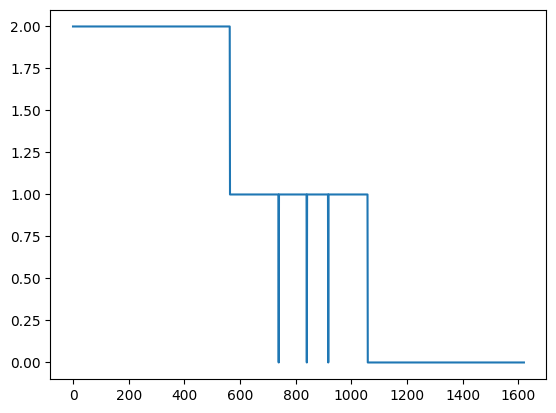

In [10]:
plt.plot(pred);

In [11]:
pred, scores = sbm_fast(graph, 3, alpha=0.01, tol=0.01, track_scores=True)

converged in 12 iterations


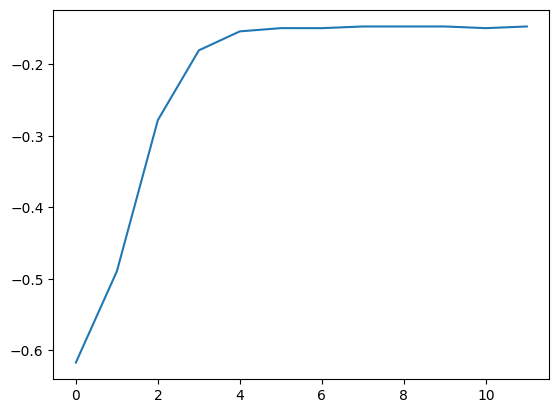

In [12]:
plt.plot(scores);

In [17]:
def cluster(X, k, *,
            alpha=0.,
            max_iter=100,
            min_epochs=10,
            tol=0.01):

    # Similarity matrix
    X_norm = X / np.linalg.norm(X, 2, axis=1, keepdims=True)
    A = X_norm @ X_norm.T

    # Soft partition matrix
    X = np.ones((X.shape[0], k)) / k
    X += np.random.randn(X.shape[0], k) / 100
    # Hard partition matrix
    Z = hardmax(X)
    partition = Z.argmax(1)

    # Structure matrix sufficient statistics
    M = Z.T @ A @ Z
    n = Z.sum(0)[:, None]
    # Structure matrix MLE
    B = M / (n@n.T).clip(1, None)

    # Regularization
    R = np.eye(k) * alpha

    for epoch in range(max_iter):

        # Perform fisher scoring updates
        ZB = B.T[partition, :]
        hess = ZB.T @ ZB + R
        grad = ZB.T @ A
        X = (X - Z) + np.linalg.solve(hess, grad).T

        # Recompute structure matrix
        Z = hardmax(X)
        M = Z.T @ A @ Z
        n = Z.sum(0)[:, None]
        B = M / (n@n.T).clip(1, None)

        # Early stopping
        prev_partition = partition
        partition = Z.argmax(1)
        if epoch > min_epochs and (prev_partition == partition).mean() > 1-tol:
            print('converged in', epoch+1, 'iterations')
            break

    else:
        print('did not converge after', max_iter, 'iterations')

    return partition


In [18]:
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=300, n_features=10,
                           n_clusters_per_class=1, n_classes=3, flip_y=0, class_sep=1.)

In [19]:
cluster(X, 3, alpha=0.1)

did not converge after 100 iterations


array([0, 0, 0, 1, 0, 0, 2, 1, 2, 0, 0, 2, 2, 2, 2, 2, 1, 1, 2, 0, 0, 0,
       2, 1, 2, 1, 0, 1, 0, 2, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 2, 1, 2, 0,
       0, 2, 1, 0, 0, 2, 0, 1, 1, 1, 1, 2, 0, 1, 1, 2, 0, 0, 0, 2, 0, 0,
       0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 2, 0, 2, 1, 0, 2, 2, 2, 2, 0, 2, 2,
       0, 2, 0, 1, 1, 0, 1, 2, 1, 2, 2, 1, 0, 1, 1, 0, 1, 1, 0, 1, 2, 0,
       2, 1, 0, 2, 2, 2, 2, 0, 1, 1, 1, 2, 2, 1, 1, 2, 2, 1, 2, 2, 2, 1,
       2, 1, 1, 2, 0, 1, 1, 2, 0, 1, 2, 0, 2, 0, 2, 2, 0, 1, 0, 2, 1, 0,
       2, 2, 2, 0, 1, 2, 2, 0, 2, 0, 2, 1, 0, 2, 0, 0, 1, 2, 1, 0, 2, 2,
       2, 1, 1, 0, 2, 1, 1, 2, 1, 1, 1, 1, 0, 0, 1, 2, 1, 2, 2, 2, 2, 0,
       0, 2, 1, 1, 0, 1, 1, 1, 0, 0, 1, 2, 2, 2, 2, 0, 1, 1, 0, 1, 0, 1,
       1, 2, 1, 2, 1, 1, 1, 2, 0, 1, 1, 1, 0, 2, 2, 2, 1, 2, 0, 2, 1, 1,
       1, 1, 1, 2, 0, 1, 0, 0, 1, 1, 0, 1, 1, 2, 0, 2, 0, 1, 2, 0, 1, 0,
       2, 0, 2, 2, 1, 1, 1, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 1,
       0, 2, 1, 1, 0, 1, 0, 0, 0, 2, 1, 2, 1, 1])